In [491]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import statsmodels.formula.api as smf
from scipy.stats import mstats

# Suppress annoying harmless error.
pd.options.mode.chained_assignment = None

## Unit 2 Lesson 4 Project 2 DRILL: Prepare the Data

[Download the Excel file here](https://ucr.fbi.gov/crime-in-the-u.s/2013/crime-in-the-u.s.-2013/tables/table-8/table-8-state-cuts/table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls) on crime data in New York State in 2013, provided by the FBI: UCR ([Thinkful mirror](https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/New_York_offenses/NEW_YORK-Offenses_Known_to_Law_Enforcement_by_City_2013%20-%2013tbl8ny.csv)).

Prepare this data to model with multivariable regression (including data cleaning if necessary) according to this specification:

$$ Property crime = \alpha + Population + Population^2 + Murder + Robbery$$

The 'population' variable is already set for you, but you will need to create the last three features.  Robbery and Murder are currently continuous variables.  For this model, please use these variables to create  categorical features where values greater than 0 are coded 1, and values equal to 0 are coded 0.  You'll use this data and model in a later assignment- for now, just write the code you need to get the data ready.  Don't forget basic data cleaning procedures, either!  Do some graphing to see if there are any anomalous cases, and decide how you want to deal with them.


In [443]:
path = ("https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/New_York_offenses/" + 
       "NEW_YORK-Offenses_Known_to_Law_Enforcement_by_City_2013%20-%2013tbl8ny.csv")

df = pd.read_csv(path, header=4)

In [444]:
df.head()

,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3
0,Adams Village,"1,861",0,0.0,NaN,0,0,0,12,2,10,0,0.0
1,Addison Town and Village,"2,577",3,0.0,NaN,0,0,3,24,3,20,1,0.0
2,Akron Village,"2,846",3,0.0,NaN,0,0,3,16,1,15,0,0.0
3,Albany,"97,956",791,8.0,NaN,30,227,526,"4,090",705,"3,243",142,NaN
4,Albion Village,"6,388",23,0.0,NaN,3,4,16,223,53,165,5,NaN


In [445]:
df.columns

Index(['City', 'Population', 'Violent\ncrime',
       'Murder and\nnonnegligent\nmanslaughter',
       'Rape\n(revised\ndefinition)1', 'Rape\n(legacy\ndefinition)2',
       'Robbery', 'Aggravated\nassault', 'Property\ncrime', 'Burglary',
       'Larceny-\ntheft', 'Motor\nvehicle\ntheft', 'Arson3'],
      dtype='object')

In [446]:
df.drop(['Rape\n(revised\ndefinition)1'], axis=1, inplace=True) #column is NaN
df.replace(',','', inplace=True, regex=True)

In [447]:
crime = df[['Property\ncrime', 'Population', 'Murder and\nnonnegligent\nmanslaughter', 'Robbery', 'Violent\ncrime']]
crime.columns = ['prop_crime', 'population', 'murder', 'robbery', 'crime']

Let's see how many rows we have

In [448]:
len(crime)

351

In [449]:
print('rows with at least one nan value: {}'.format(len(crime[crime.isna().any(1)])))
print('rows with all nan value: {}'.format(len(crime[crime.isna().all(1)])))

rows with at least one nan value: 3
rows with all nan value: 3


Three rows in the dataframe have missing values (they're actually missing all values), so we're gonna drop those rows out

In [450]:
crime.dropna(inplace=True)

Make sure we don't have a value smaller than zero

In [451]:
crime.min()

prop_crime       0.0
population    1022.0
murder           0.0
robbery          0.0
crime            0.0
dtype: float64

In [452]:
crime.dtypes

prop_crime     object
population     object
murder        float64
robbery        object
crime          object
dtype: object

Trying to turn robbery data type to an integer throws an error due to dots and commas in the strings that we need to remove

In [453]:
#example
crime.robbery[35]

'1322'

In [454]:
crime.replace(',', '', inplace=True)

In [455]:
crime.robbery[35]

'1322'

In [456]:
crime.murder.dtype

dtype('float64')

In [457]:
for col in crime.columns:
    if crime[col].dtype != 'float64':
        crime[col] = crime[col].str.replace(',', '')

In [458]:
categoricals = ['murder', 'robbery']
crime = crime.astype(int)
crime[categoricals] = crime[categoricals].applymap(lambda x: 1 if x > 0 else 0)

We also have to add the squared population

In [459]:
crime.head()

,prop_crime,population,murder,robbery,crime
0,12,1861,0,0,0
1,24,2577,0,0,3
2,16,2846,0,0,3
3,4090,97956,1,1,791
4,223,6388,0,1,23


### Find outliers
We're going to check for anomaly cases now

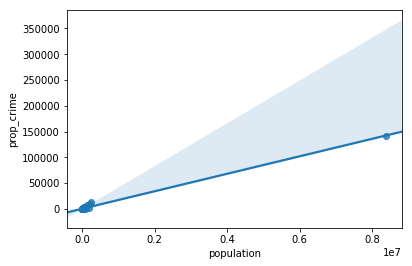

In [460]:
sns.regplot(crime.population, crime.prop_crime)
plt.show()

What we clearly see here is a lot of smaller towns and the big city NYC. Which results in a huge difference in both property crime and population, our two continous variables

We're going to apply a logaritmic transformation to reduce that gap

In [461]:
crime['pop_log'] = crime['population'].apply(lambda x: np.log(x) if x > 0 else x)
crime['prop_crime_log'] = crime['prop_crime'].apply(lambda x: np.log(x) if x > 0 else x)

In [462]:
crime.describe().round(2)

,prop_crime,population,murder,robbery,crime,pop_log,prop_crime_log
count,348.00,348.00,348.00,348.00,348.00,348.00,348.00
mean,792.61,40037.63,0.14,0.60,201.59,8.96,4.70
std,7659.72,450037.37,0.35,0.49,2815.27,1.25,1.73
min,0.00,526.00,0.00,0.00,0.00,6.27,0.00
25%,40.50,3003.00,0.00,0.00,2.00,8.01,3.70
50%,112.50,7233.50,0.00,1.00,6.00,8.89,4.72
75%,341.00,18427.50,0.00,1.00,22.00,9.82,5.83
max,141971.00,8396126.00,1.00,1.00,52384.00,15.94,11.86


It looks much better now

In [463]:
pop_no_outliers = crime['pop_log'][crime['pop_log'] != max(crime['pop_log'])]
prop_no_outliers = crime['prop_crime_log'][crime['prop_crime_log'] != max(crime['prop_crime_log'])]

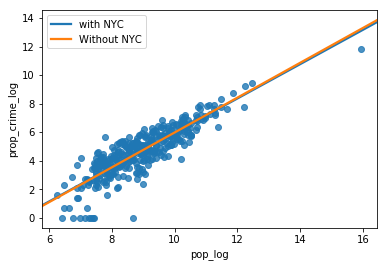

In [464]:
sns.regplot(crime.pop_log, crime.prop_crime_log, ci=None)
sns.regplot(pop_no_outliers, prop_no_outliers, scatter=False, ci=None)
plt.legend(['with NYC', 'Without NYC'])
plt.show()

the resgression line doesn't vary much with or wihtout that data point

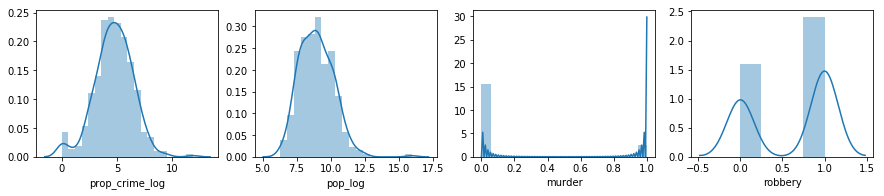

In [465]:
crime_vars = crime[['prop_crime_log', 'pop_log', 'murder', 'robbery']]

fig, ax = plt.subplots(1, 4, figsize=(15,2.7))
for var, ax in list(zip(crime_vars, ax)):
    sns.distplot(crime[var], ax=ax)
plt.show()

In [466]:
list(zip(crime_vars, ('1', '2', '2', '4')))

[('prop_crime_log', '1'), ('pop_log', '2'), ('murder', '2'), ('robbery', '4')]

In [467]:
crime['pop_log2'] = crime.pop_log**2

## Unit 2 Lesson 4 Project 4: Challenge: make your own regression model

Now that you've spent some time playing with a sample multivariate linear regression model, it's time to make your own.

You've already gotten started by prepping the FBI:UCR Crime dataset (Thinkful mirror) in a previous assignment.

Using this data, build a regression model to predict property crimes. You can use the features you prepared in the previous assignment, new features of your own choosing, or a combination. The goal here is prediction rather than understanding mechanisms, so the focus is on creating a model that explains a lot of variance.

Submit a notebook with your model and a brief writeup of your feature engineering and selection process to submit and review with your mentor.


### Fit model using Sklearn

In [468]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = crime['prop_crime']
X = crime[['pop_log','pop_log2','murder', 'robbery']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [-37386.91700087   2128.17185195  -3039.86528967    515.83278823]

Intercept: 
 161755.83074222377

R-squared:
0.7627389614365483


(array([  1.,   0.,   0.,   0.,   0.,   9., 240.,  80.,  17.,   1.]),
 array([-37853.13464861, -32315.24939782, -26777.36414704, -21239.47889625,
        -15701.59364546, -10163.70839468,  -4625.82314389,    912.06210689,
          6449.94735768,  11987.83260847,  17525.71785925]),
 <a list of 10 Patch objects>)

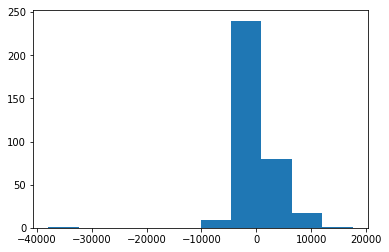

In [469]:
predicted = regr.predict(X).ravel()
actual = crime['prop_crime']
residual = predicted - actual

plt.hist(residual)

### Fit model using StatsModels

In [470]:
data = crime[['prop_crime', 'pop_log', 'pop_log2', 'murder', 'robbery']]

linear_formula = 'prop_crime ~ pop_log+pop_log2+murder+robbery'

lm = smf.ols(formula=linear_formula, data=data).fit()

lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             prop_crime   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     275.7
Date:                Wed, 14 Mar 2018   Prob (F-statistic):          9.36e-106
Time:                        22:40:25   Log-Likelihood:                -3355.4
No. Observations:                 348   AIC:                             6721.
Df Residuals:                     343   BIC:                             6740.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.618e+05   6563.823     24.644      0.000    1.49e+05    1.75e+05
pop_log    -3.739e+04   1389.826    -26.900      0.000   -4.01e+04   -3.47e+04
pop_log2    2128.1719     72.374     29.405      0.000    1985.819    2270.524
murder     -3039.8653    678.664     -4.479      0.000   -4374.732   -1704.999
robbery      515.8328    521.110      0.990      0.323    -509.140    1540.806
==============================================================================
Omnibus:                      224.167   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14598.036
Skew:                           1.885   Prob(JB):                         0.00
Kurtosis:                      34.505   Cond. No.                     2.85e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.85e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Increase variance explained by model with new features

__Drop robbery and include larceny__

We're gonna remove Robbery from our model as it's p-value is higher than 0.05, and find another feature looking at the correlation map

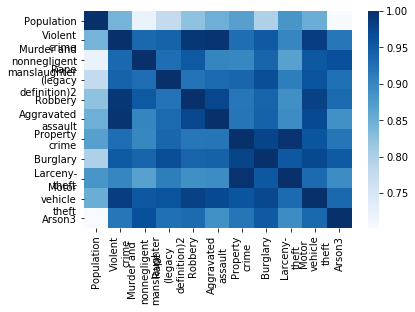

In [471]:
corr = df.dropna()
corr.loc[:, corr.columns != 'City'] = corr.loc[:, corr.columns != 'City'].astype(int)
sns.heatmap(corr.corr(), cmap="Blues")

Larcecy and property crime seem to be very correlated (in fact larcency punishes the taking of property in nonviolent face-to-face encounters)

In [472]:
crime['larceny'] = df['Larceny-\ntheft']
crime = crime.astype(int)

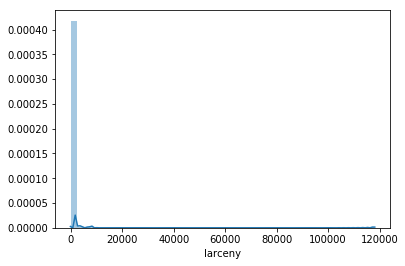

In [473]:
sns.distplot(crime.larceny)

In [474]:
crime['lar_log'] = crime['larceny'].apply(lambda x: np.log(x) if x > 0 else x)

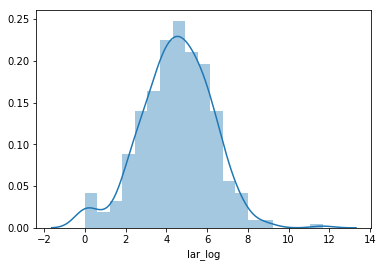

In [475]:
sns.distplot(crime.lar_log)

In [476]:
data = crime[['prop_crime', 'pop_log', 'pop_log2', 'murder', 'lar_log']]

linear_formula = 'prop_crime ~ pop_log+pop_log2+murder+lar_log'

lm = smf.ols(formula=linear_formula, data=data).fit()

In [477]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             prop_crime   R-squared:                       0.397
Model:                            OLS   Adj. R-squared:                  0.390
Method:                 Least Squares   F-statistic:                     56.49
Date:                Wed, 14 Mar 2018   Prob (F-statistic):           1.40e-36
Time:                        22:40:28   Log-Likelihood:                -3517.7
No. Observations:                 348   AIC:                             7045.
Df Residuals:                     343   BIC:                             7065.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.383e+04   4297.196      5.545      0.000    1.54e+04    3.23e+04
pop_log    -8729.0749    973.516     -8.967      0.000   -1.06e+04   -6814.261
pop_log2     685.3351     54.377     12.603      0.000     578.381     792.289
murder     -1692.3185   1080.807     -1.566      0.118   -3818.163     433.526
lar_log    -1033.4316    361.605     -2.858      0.005   -1744.674    -322.189
==============================================================================
Omnibus:                      593.529   Durbin-Watson:                   1.885
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           292527.859
Skew:                           9.491   Prob(JB):                         0.00
Kurtosis:                     143.762   Cond. No.                     1.17e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.17e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

R2 is high, very high. Since larceny and prop crime are closely related, might we be overfitting?? check that

__Use only larceny as parameter__

In [478]:
data = crime[['prop_crime', 'lar_log']]

linear_formula = 'prop_crime ~ lar_log'

lm = smf.ols(formula=linear_formula, data=data).fit()

In [479]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             prop_crime   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     32.39
Date:                Wed, 14 Mar 2018   Prob (F-statistic):           2.70e-08
Time:                        22:40:28   Log-Likelihood:                -3590.1
No. Observations:                 348   AIC:                             7184.
Df Residuals:                     346   BIC:                             7192.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -5042.1642   1098.098     -4.592      0.000   -7201.952   -2882.376
lar_log     1299.7479    228.391      5.691      0.000     850.538    1748.958
==============================================================================
Omnibus:                      782.309   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1324371.046
Skew:                          16.834   Prob(JB):                         0.00
Kurtosis:                     303.337   Cond. No.                         13.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

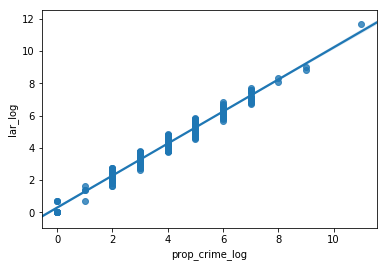

In [480]:
sns.regplot(crime['prop_crime_log'], crime['lar_log'])

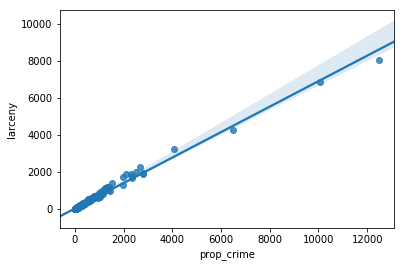

In [481]:
scatter = crime.sort_values('prop_crime')[:-1] #drop highest value
sns.regplot(scatter['prop_crime'], scatter['larceny'])

### Use crime and population

In [482]:
df[df.City == 'New York']

,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3
216,New York,8396126,52384,335.0,1112,19170,31767,141971,16606,117931,7434,NaN


In [483]:
no_NY = crime.drop([216])

In [484]:
X = no_NY[['population', 'crime']]
Y = no_NY['prop_crime']
regr.fit(X, Y)

# Inspect the results
print("\nCoefficients: ", regr.coef_)
print("\nIntercept: ", regr.intercept_)
print("\nR-squared: ", regr.score(X, Y))


Coefficients:  [0.01272657 2.9194755 ]

Intercept:  33.16243744031635

R-squared:  0.926436560647587


## Unit 2 Lesson 5 Project 2: Validating regression models for prediction
Statistical tests are useful for making sure a model is a good fit to the test data, and that all the features are useful to the model. However, to make sure a model has good predictive validity for new data, it is necessary to assess the performance of the model on new datasets.

The procedure is the same as what you learned in the Naive Bayes lesson – the holdout method and cross-validation method are both available. You've already had experience writing code to run these kinds of validation models for Naive Bayes: now you can try it again with linear regression. In this case, your goal is to achieve a model with a consistent R2 and only statistically significant parameters across multiple samples.

We'll use the property crime model you've been working on with, based on the FBI:UCR data. Since your model formulation to date has used the entire New York State 2013 dataset, you'll need to validate it using some of the other crime datasets available at the FBI:UCR website. Options include other states crime rates in 2013 or crime rates in New York State in other years or a combination of these.

Iterate
Based on the results of your validation test, create a revised model, and then test both old and new models on a new holdout or set of folds.

Include your model(s) and a brief writeup of the reasoning behind the validation method you chose and the changes you made to submit and review with your mentor.

## Winsorize data
Previously we applied logaritmic transformation to a few variables to deal with NYC which is a big outliers in our data. However, this has thrown some weird numbers when running holdout groups and cross_validation, so we're actually gonnat take a step back and winsorize our data and try again

In [495]:
crime_win = crime.copy()
for var in ('population', 'prop_crime', 'larceny'):
    crime_win[var] = mstats.winsorize(crime[var], limits=0.05)

let's check one of the variables we just winsorized

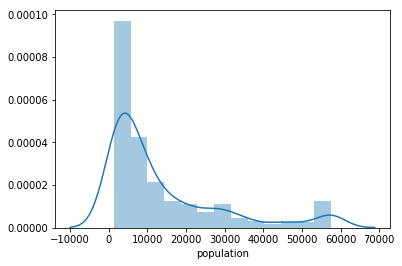

In [486]:
sns.distplot(crime_win['population'])

## Initial model - pop + murder + robbery

In [496]:
data = crime_win[['population', 'murder', 'robbery']]
target = crime_win['prop_crime']

### Holdout groups

In [497]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=20)
print('With 20% Holdout: ' + str(regr.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(regr.fit(data, target).score(data, target)))

With 20% Holdout: 0.8193148437578158
Testing on Sample: 0.8152805602879983


### Cross-validation

In [498]:
regr = linear_model.LinearRegression()
list(cross_val_score(regr, data, target, cv=10))

[0.920633667437209,
 0.9122238936447106,
 0.3909221061881496,
 0.7242197190295078,
 0.7538231180859716,
 0.7573324598046066,
 0.7185323340310455,
 0.7976144619772622,
 0.8706934525953842,
 0.851922911211691]

## Improved model - oh yeah

### Holdout groups

In [487]:
data = crime_win[['population', 'larceny']]
target = crime_win['prop_crime']

In [490]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=20)
print('With 20% Holdout: ' + str(regr.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(regr.fit(data, target).score(data, target)))

With 20% Holdout: 0.9966521374469293
Testing on Sample: 0.9930150762078515


### Cross validation

In [492]:
regr = linear_model.LinearRegression()
list(cross_val_score(regr, data, target, cv=10))

[0.9983676663311184,
 0.9982950630714492,
 0.9864995302884441,
 0.9940389888250568,
 0.981056234104225,
 0.9629237133117113,
 0.9977803263797733,
 0.9944820122181174,
 0.9963152072023614,
 0.9943035134550573]